##**1.1. Installing necesarry packages**

In [139]:
!pip install -q torch_snippets
!pip install -q torchinfo
!pip install -q torchmetrics

from torchmetrics import ConfusionMatrix
from torch_snippets import*
from torchinfo import summary
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report
import pandas as pd

In [140]:
device="cuda" if torch.cuda.is_available() else "cpu"
device #device agniostic code

'cuda'

##**1.2. Getting the data**

In [141]:
transformer= transforms.Compose([transforms.ToTensor()]) #dataset contains imgs in PIL format

In [142]:
train_ds=datasets.MNIST(root="MNIST/", train=True, download=True, transform= transformer)
#convert labels to one hot encoding
test_ds=datasets.MNIST(root="MNIST/", train=False, download=True, transform= transformer)

train_dl= torch.utils.data.DataLoader(train_ds, batch_size=64, drop_last=True)
test_dl= torch.utils.data.DataLoader(test_ds, batch_size=64, drop_last=True)

In [143]:
im, label=next(iter(train_dl))
im.shape, label.shape #labels are not one hot encoded; img_shape-> [28*28]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

##**1.3. Building the model**

In [144]:
model= nn.Sequential(nn.Conv2d(1, 32, 3, stride=1, padding=1), #since image is in black and white the in_channel=1
                     nn.ReLU(),
                     nn.MaxPool2d(2, stride=2),
                     nn.Conv2d(32, 32, 3, stride=1, padding=1),
                     nn.ReLU(),
                     nn.MaxPool2d(2, stride=2),
                     nn.Flatten(),
                     nn.Linear(1568, 500), #here we need to choose the input dim correctly
                     nn.ReLU(),
                     nn.Linear(500, 10),
                     nn.Softmax(dim=-1)).to(device)

In [145]:
#model(im) #we use forward pass for one training sample to figure out the in_dim for the first linear layer

In [146]:
summary(model, input_size=(64, 1, 28, 28), col_names=["num_params", "input_size", "output_size", "trainable"])

Layer (type:depth-idx)                   Param #                   Input Shape               Output Shape              Trainable
Sequential                               --                        [64, 1, 28, 28]           [64, 10]                  True
├─Conv2d: 1-1                            320                       [64, 1, 28, 28]           [64, 32, 28, 28]          True
├─ReLU: 1-2                              --                        [64, 32, 28, 28]          [64, 32, 28, 28]          --
├─MaxPool2d: 1-3                         --                        [64, 32, 28, 28]          [64, 32, 14, 14]          --
├─Conv2d: 1-4                            9,248                     [64, 32, 14, 14]          [64, 32, 14, 14]          True
├─ReLU: 1-5                              --                        [64, 32, 14, 14]          [64, 32, 14, 14]          --
├─MaxPool2d: 1-6                         --                        [64, 32, 14, 14]          [64, 32, 7, 7]            --
├─Flatten: 

###**Model Params**

1.   Model- total params: 799078 [All trainable]
2.   CNN_layers params: 9568
3.   FullyConnected_layers params: 789510



###**Number of neurons**


1.   Model- total neurons: 32(conv) +1(maxpool)+ 32(conv) +1(maxpool) +500(FC) +10(FC) =576
2.   CNN_layers neurons: 64
3.   FullyConnected_layers neurons: 510



##**1.4. Training the model**

In [147]:
def acc(y_t, y_p):
  y_p= torch.argmax(y_p, dim=-1)
  return torch.sum(torch.eq(y_t, y_p))/len(y_t)

In [148]:
def train_epoch(model, input, criterion, optimizer):
  x, y= input
  x, y= x.to(device), y.to(device)
  model.train()
  output=model(x)
  loss=criterion(output, y)
  accuracy= acc(y, output)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss.item(), accuracy.item()

def val_epoch(model, input, criterion):
  x, y= input
  x, y= x.to(device), y.to(device)
  model.eval()
  with torch.inference_mode():
    output=model(x)
    loss=criterion(output, y)
    accuracy= acc(y, output)
    return loss.item(), accuracy.item()

In [149]:
EPOCHS=7 #the val acc seems to saturate after 5th epoch
criterion= torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters())

In [150]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(train_dl)
  for ix, input in enumerate(train_dl):
    loss, accuracy=train_epoch(model, input, criterion, optimizer)
    log.record(epoch+(ix+1)/n, train_loss=loss, train_acc= accuracy, end="\r")
  n=len(test_dl)
  for ix, input in enumerate(test_dl):
    loss, accuracy=val_epoch(model, input, criterion)
    log.record(epoch+(ix+1)/n, val_loss=loss, val_acc= accuracy, end="\r")
  log.report_avgs(epoch+1)

EPOCH: 1.000  val_acc: 0.972  train_acc: 0.839  val_loss: 1.490  train_loss: 1.626  (19.92s - 119.54s remaining)
EPOCH: 2.000  val_acc: 0.983  train_acc: 0.975  val_loss: 1.478  train_loss: 1.487  (32.64s - 81.60s remaining)
EPOCH: 3.000  val_acc: 0.987  train_acc: 0.984  val_loss: 1.475  train_loss: 1.478  (44.28s - 59.04s remaining)
EPOCH: 4.000  val_acc: 0.987  train_acc: 0.985  val_loss: 1.475  train_loss: 1.476  (55.99s - 41.99s remaining)
EPOCH: 5.000  val_acc: 0.985  train_acc: 0.988  val_loss: 1.476  train_loss: 1.473  (67.36s - 26.95s remaining)
EPOCH: 6.000  val_acc: 0.986  train_acc: 0.990  val_loss: 1.475  train_loss: 1.472  (79.76s - 13.29s remaining)
EPOCH: 7.000  val_acc: 0.984  train_acc: 0.990  val_loss: 1.477  train_loss: 1.471  (91.17s - 0.00s remaining)


100%|██████████| 108/108 [00:00<00:00, 274.20it/s]


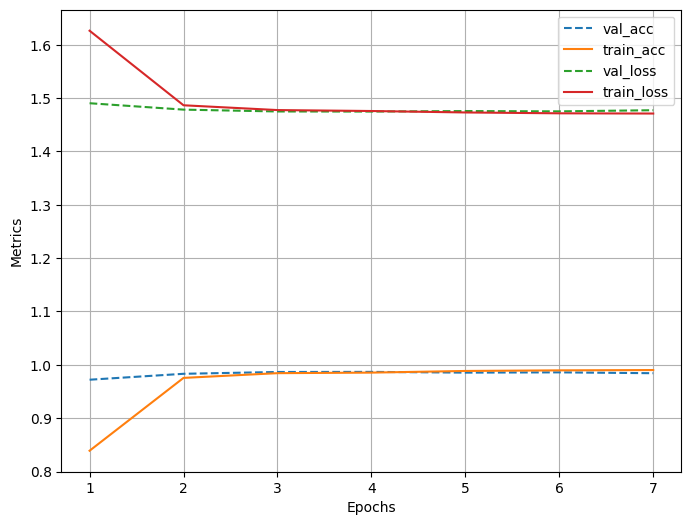

In [151]:
log.plot_epochs()

###**Plotting the predictions**

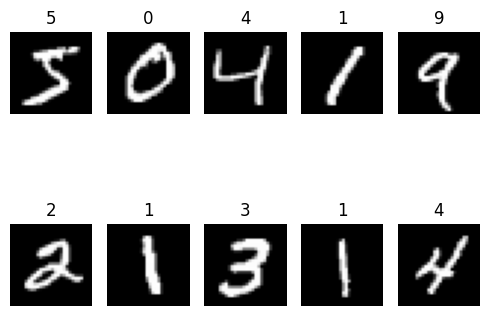

In [152]:
probs=torch.argmax(model(im[:10].to(device)), dim=-1)
probs= [str(i.item()) for i in probs]
subplots(im[:10].detach().squeeze().numpy(), nc=5, titles= probs)

##**1.5. Model with batch normalization**

In [153]:
bn_model= nn.Sequential(nn.Conv2d(1, 32, 3, stride=1, padding=1), #since image is in black and white the in_channel=1
                     nn.ReLU(),
                     nn.BatchNorm2d(num_features= 32),
                     nn.MaxPool2d(2, stride=2),
                     nn.Conv2d(32, 32, 3, stride=1, padding=1),
                    #  nn.BatchNorm2d(num_features= 32),
                     nn.ReLU(),
                     nn.MaxPool2d(2, stride=2),
                     nn.Flatten(),
                     nn.Linear(1568, 500), #here we need to choose the input dim correctly
                     nn.ReLU(),
                     nn.Linear(500, 10),
                     nn.Softmax(dim=-1)).to(device)

In [154]:
summary(bn_model, input_size=(64, 1, 28, 28), col_names=["num_params", "input_size", "output_size", "trainable"])

Layer (type:depth-idx)                   Param #                   Input Shape               Output Shape              Trainable
Sequential                               --                        [64, 1, 28, 28]           [64, 10]                  True
├─Conv2d: 1-1                            320                       [64, 1, 28, 28]           [64, 32, 28, 28]          True
├─ReLU: 1-2                              --                        [64, 32, 28, 28]          [64, 32, 28, 28]          --
├─BatchNorm2d: 1-3                       64                        [64, 32, 28, 28]          [64, 32, 28, 28]          True
├─MaxPool2d: 1-4                         --                        [64, 32, 28, 28]          [64, 32, 14, 14]          --
├─Conv2d: 1-5                            9,248                     [64, 32, 14, 14]          [64, 32, 14, 14]          True
├─ReLU: 1-6                              --                        [64, 32, 14, 14]          [64, 32, 14, 14]          --
├─MaxPool

In [155]:
log= Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(train_dl)
  for ix, input in enumerate(train_dl):
    loss, accuracy=train_epoch(bn_model, input, criterion, optimizer)
    log.record(epoch+(ix+1)/n, train_loss=loss, train_acc= accuracy, end="\r")
  n=len(test_dl)
  for ix, input in enumerate(test_dl):
    loss, accuracy=val_epoch(bn_model, input, criterion)
    log.record(epoch+(ix+1)/n, val_loss=loss, val_acc= accuracy, end="\r")
  log.report_avgs(epoch+1)

EPOCH: 1.000  val_acc: 0.117  train_acc: 0.115  val_loss: 2.302  train_loss: 2.302  (19.87s - 119.25s remaining)
EPOCH: 2.000  val_acc: 0.117  train_acc: 0.115  val_loss: 2.302  train_loss: 2.302  (31.77s - 79.43s remaining)
EPOCH: 3.000  val_acc: 0.117  train_acc: 0.115  val_loss: 2.302  train_loss: 2.302  (43.05s - 57.41s remaining)
EPOCH: 4.000  val_acc: 0.117  train_acc: 0.115  val_loss: 2.302  train_loss: 2.302  (54.36s - 40.77s remaining)
EPOCH: 5.000  val_acc: 0.117  train_acc: 0.115  val_loss: 2.302  train_loss: 2.302  (65.50s - 26.20s remaining)
EPOCH: 6.000  val_acc: 0.117  train_acc: 0.115  val_loss: 2.302  train_loss: 2.302  (76.75s - 12.79s remaining)
EPOCH: 7.000  val_acc: 0.117  train_acc: 0.115  val_loss: 2.302  train_loss: 2.302  (88.36s - 0.00s remaining)


###**Val loss has increased and val accuracy has fallen down but training time has decreased considerably**

100%|██████████| 108/108 [00:00<00:00, 295.47it/s]


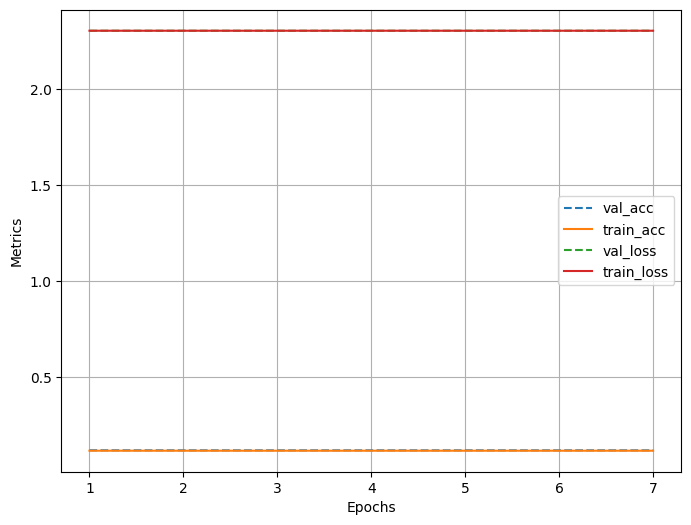

In [156]:
log.plot_epochs()

##**1.6.Plotting the conv filters**

In [157]:
conv1_f=list(model[0].parameters())[0].detach().to("cpu") #index_1 corresbonds to the biasis
conv2_f=list(model[3].parameters())[0].detach().to("cpu")

In [158]:
conv1_f=model[0].weight.detach().to("cpu")
conv2_f=model[3].weight.detach().to("cpu")

In [159]:
# conv1_f=(conv1_f-torch.min(conv1_f))/(torch.max(conv1_f)-torch.min(conv1_f)) #normalization
# conv2_f=(conv2_f-torch.min(conv2_f))/(torch.max(conv2_f)-torch.min(conv2_f))

conv1_f.shape, conv2_f.shape

(torch.Size([32, 1, 3, 3]), torch.Size([32, 32, 3, 3]))

In [160]:
grid_f1=torchvision.utils.make_grid(conv1_f, nrow=8, normalize= True)
grid_f2=torchvision.utils.make_grid(conv2_f[:,0,:,:].unsqueeze(dim=1), nrow=8, normalize= True) #taking the 0th channel

grid_f1.shape, grid_f2.shape

(torch.Size([3, 22, 42]), torch.Size([3, 22, 42]))

###**Conv_1 Filter**

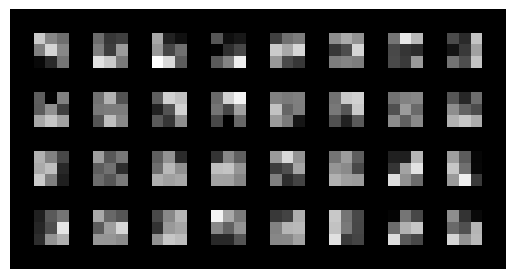

In [161]:
plt.imshow(grid_f1.permute(1,2,0))
plt.axis("off");

###**Conv_2 Filter**

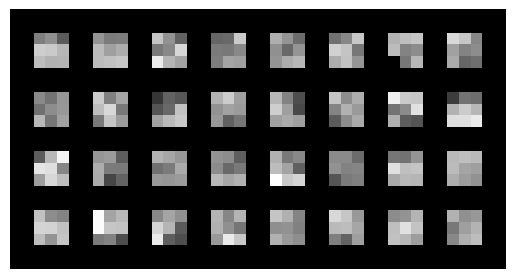

In [162]:
plt.imshow(grid_f2.permute(1,2,0))
plt.axis("off"); #channel 0 of all 32 filters

##**1.7. Plotting the activations**

In [163]:
o_conv1= model[0](im[:4].to(device))
o_conv2= model[:3](im[:4].to(device))

o_conv1.shape, o_conv2.shape

(torch.Size([4, 32, 28, 28]), torch.Size([4, 32, 14, 14]))

In [164]:
grid_o1= torchvision.utils.make_grid(o_conv1[:,0,:,:].unsqueeze(dim=1), normalize= True)
grid_o2= torchvision.utils.make_grid(o_conv2[:,0,:,:].unsqueeze(dim=1), normalize= True)

grid_o1.shape, grid_o2.shape

(torch.Size([3, 32, 122]), torch.Size([3, 18, 66]))

###**Conv_1 Activation**

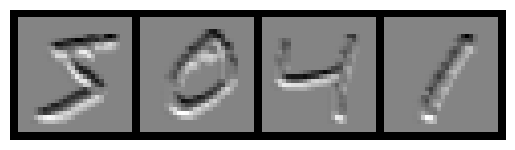

In [165]:
plt.imshow(grid_o1.permute(1,2,0).cpu())
plt.axis("off");

###**Conv_2 Activation**

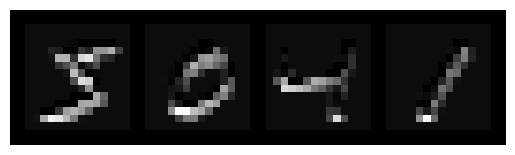

In [166]:
plt.imshow(grid_o2.permute(1,2,0).cpu())
plt.axis("off");

Conv_1 activation seems to capture basic features like the edges of the numbers.

Conv_2 activations on the other hand seems to capture higher features like the image composition as a whole.

##**1.8. Image occlusion**

In [167]:
def occlude(im, size):
  ims, pos=[], []
  n= (size-1)//2
  for i in range(n, im.shape[1]-n):
    for j in range(n, im.shape[2]-n):
      v_s, v_e= i-size//2, i+size//2
      h_s, h_e= j-size//2, j+size//2
      im_c=im.clone()
      im_c[:, v_s:v_e, h_s:h_e]=0
      ims.append(im_c)
      pos.append(str([i,j]))
  return ims, pos

In [168]:
im_occlude, pos=occlude(im[0], 5)
len(im_occlude)

576

In [169]:
i=235
grid= torchvision.utils.make_grid(im_occlude[i:i+26], nrow=13)
grid.shape

torch.Size([3, 62, 392])

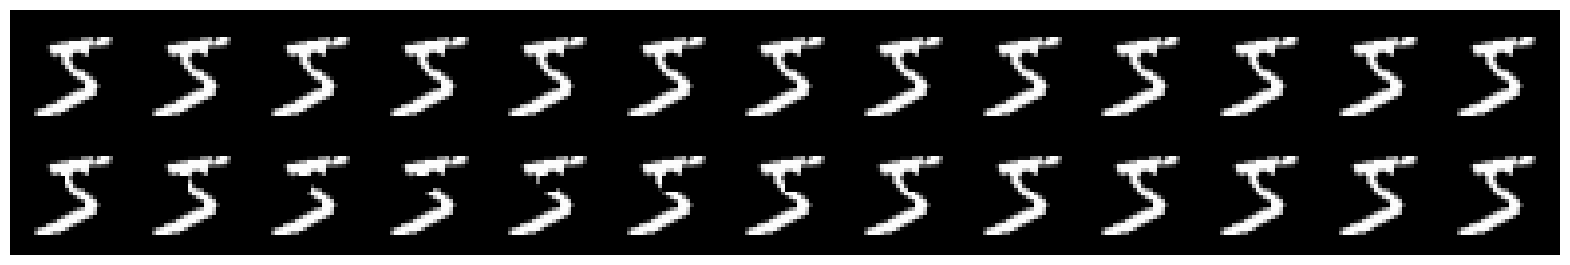

In [170]:
plt.figure(figsize=(20,7))
plt.axis("off")
plt.imshow(grid.permute(1,2,0));

In [171]:
im_occlude= torch.vstack(im_occlude).unsqueeze(dim=1)
im_occlude.shape

torch.Size([576, 1, 28, 28])

In [172]:
result_occlude=model(im_occlude.to(device))

In [173]:
probs_occlude=result_occlude[:,label[0]]

In [174]:
len(pos), len(probs_occlude)

(576, 576)

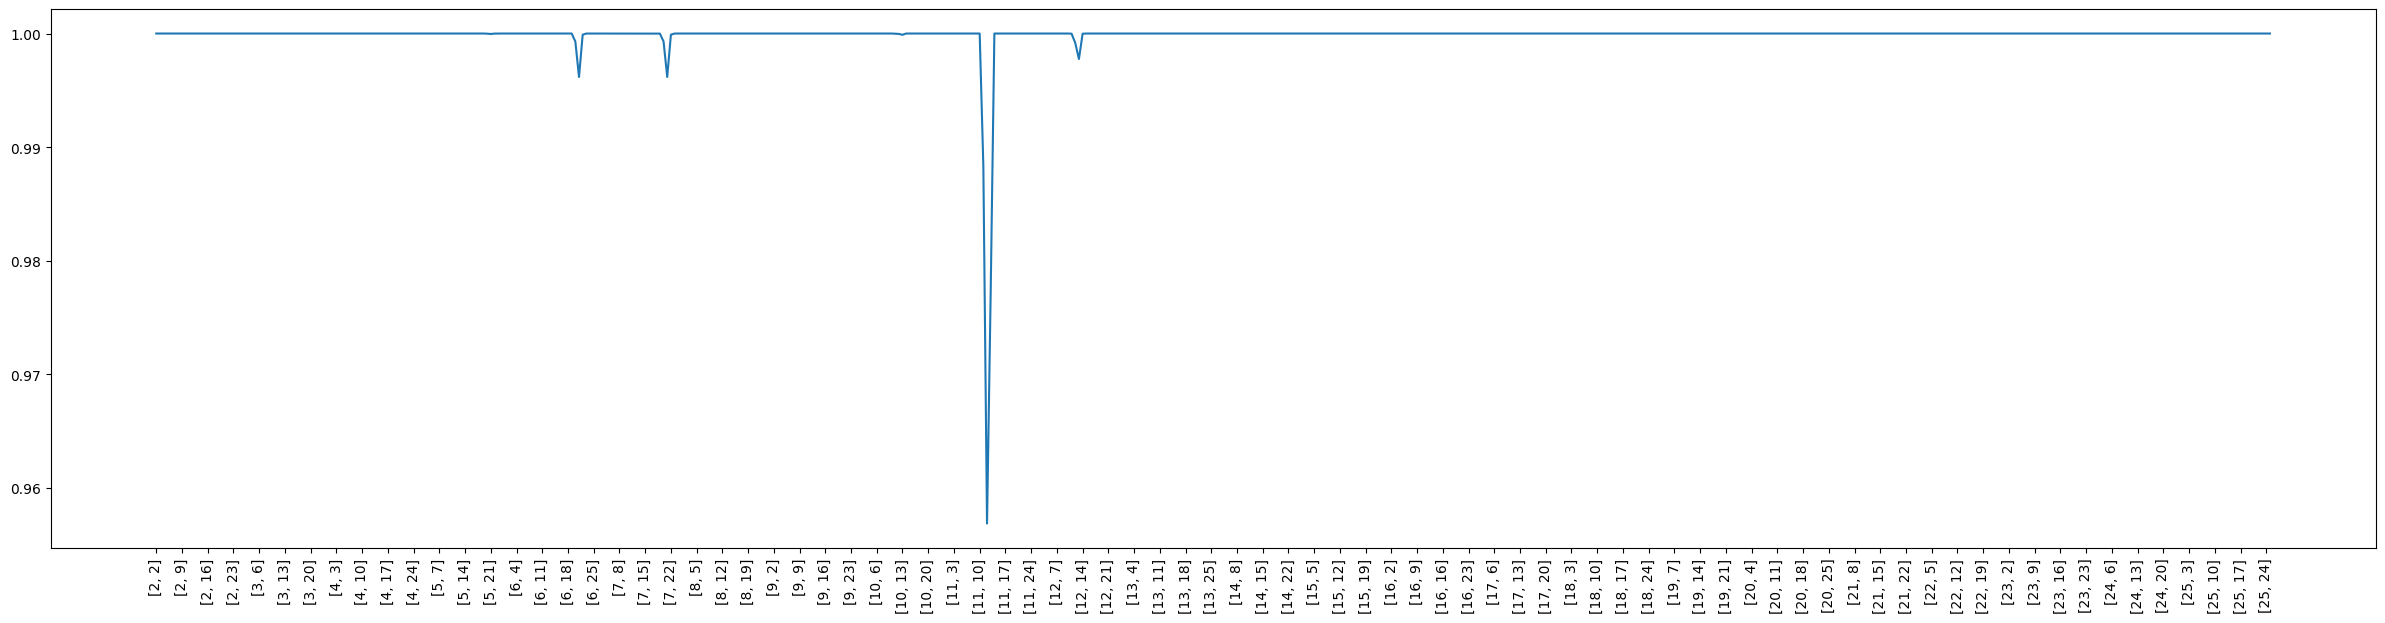

In [175]:
plt.figure(figsize=(30,7))
plt.plot(np.arange(576), probs_occlude.detach().cpu().numpy(), label="5")
plt.xticks(np.arange(576)[0: 576: 7], pos[0: 576: 7], rotation="vertical"); #the x_ticks give location of the centre of the patch

###**Generalized function for plotting the occluded_probs**

In [176]:
def plot_occluded_probs(ims, labels, size):
  fig, ax= plt.subplots(figsize=(30,7))
  for idx, im in enumerate(ims):
    im_occluded, pos=occlude(im, size)
    im_occluded= torch.vstack(im_occluded).unsqueeze(dim=1)
    result_occluded=model(im_occluded.to(device))
    probs_occluded=result_occluded[:,labels[idx]]
    ax.plot(np.arange(len(probs_occluded)), probs_occluded.detach().cpu().numpy(), label=f"{labels[idx].item()}");
    ax.grid();
    ax.set_xticks(np.arange(len(probs_occluded))[0: len(probs_occluded): 7], pos[0: len(probs_occluded): 7], rotation="vertical");
    ax.legend();

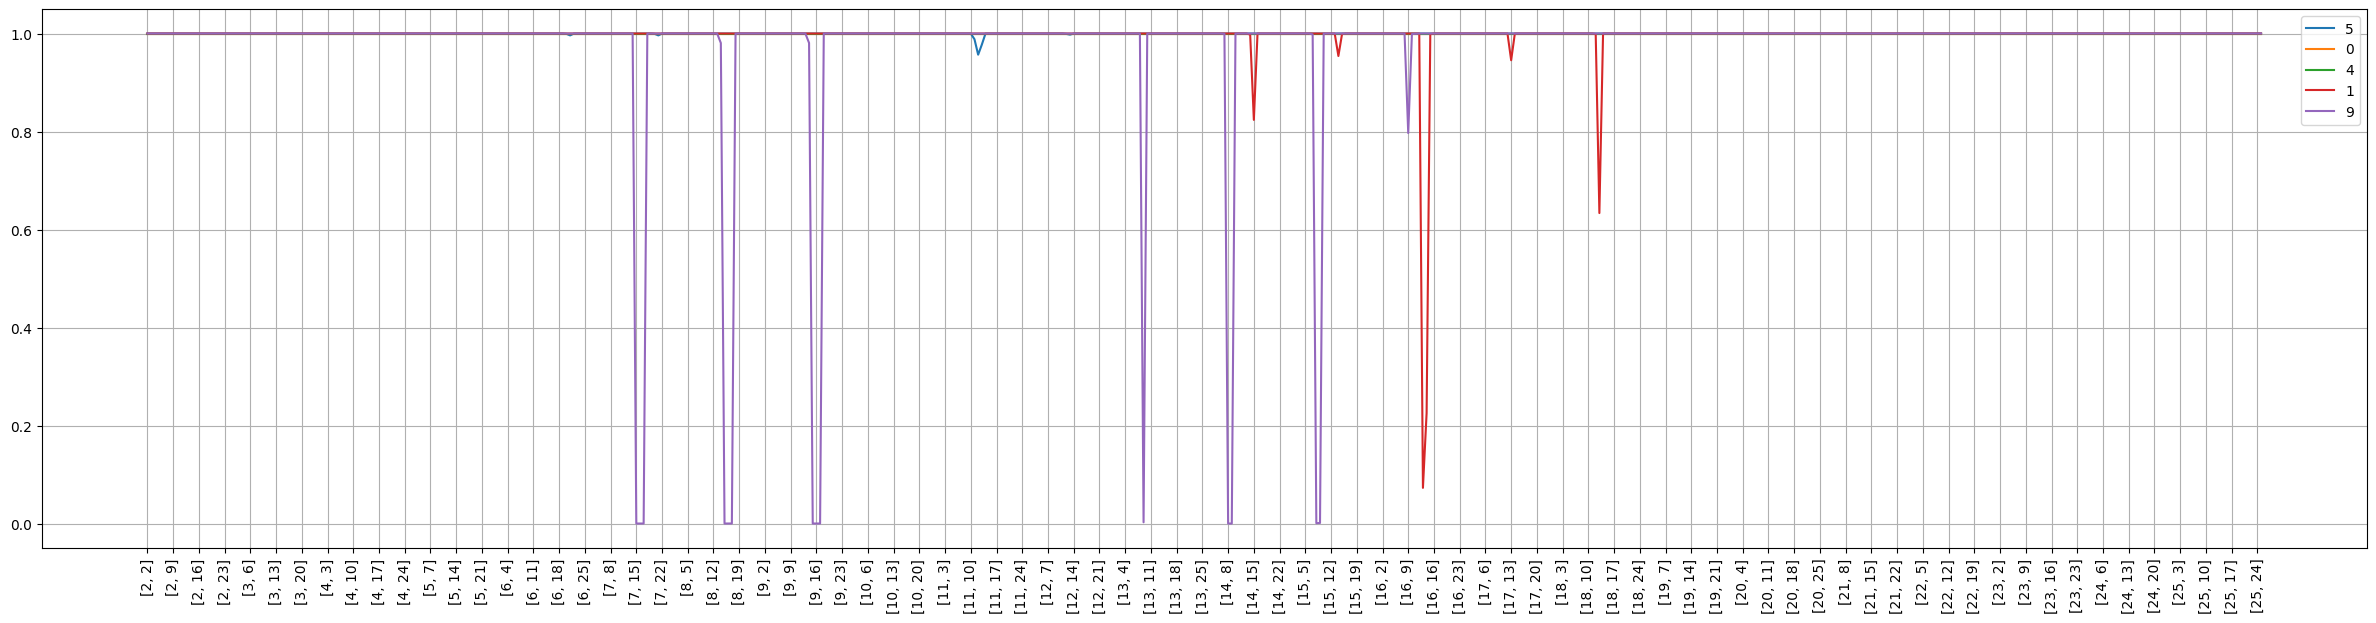

In [177]:
plot_occluded_probs(im[:5], label[:5], 5)

##**1.9. Adverserial attack**

###**1.9.1. Non targeted attack**

In [203]:
im_ad_original= -4*torch.rand((1,1,28,28), requires_grad=True)+130 #centred at 128
im_ad=torch.nn.Parameter(im_ad_original, requires_grad=True)
im_ad.shape, im_ad.is_leaf,#im_ad #this im_ad changes after train_ad

(torch.Size([1, 1, 28, 28]), True)

In [204]:
model_ad=model[:-1]

In [205]:
def train_ad(model, model_ad, optimizer, im_ad, target_class):
  model, model_ad= model.cpu(), model_ad.cpu()
  model.requires_grad_(False)
  model_ad.requires_grad_(False)
  logits= model_ad(im_ad)
  loss= -logits[0][target_class]
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  pred_probs=model(im_ad)[0][target_class]
  return loss, pred_probs

In [206]:
optimizer= torch.optim.Adam([im_ad])

In [207]:
losses, probs=[], []
for i in range(4500):
  loss, pred_probs= train_ad(model, model_ad, optimizer, im_ad, 3)
  losses.append(loss.item())
  probs.append(pred_probs.item())
  if (i+1)%100==0:
    print(f"EPOCH: {i+1} LOSS: {loss.item() :.4f} PROBS: {pred_probs.item()}")

EPOCH: 100 LOSS: -1091.4718 PROBS: 0.0

EPOCH: 200 LOSS: -1120.4670 PROBS: 0.0

EPOCH: 300 LOSS: -1147.7263 PROBS: 0.0

EPOCH: 400 LOSS: -1174.0854 PROBS: 0.0

EPOCH: 500 LOSS: -1199.6570 PROBS: 0.0

EPOCH: 600 LOSS: -1224.0520 PROBS: 0.0

EPOCH: 700 LOSS: -1247.9019 PROBS: 0.0

EPOCH: 800 LOSS: -1271.4045 PROBS: 0.0

EPOCH: 900 LOSS: -1294.4281 PROBS: 0.0

EPOCH: 1000 LOSS: -1317.9648 PROBS: 0.0

EPOCH: 1100 LOSS: -1342.1084 PROBS: 0.0

EPOCH: 1200 LOSS: -1364.6897 PROBS: 0.0

EPOCH: 1300 LOSS: -1387.4854 PROBS: 0.0

EPOCH: 1400 LOSS: -1410.9568 PROBS: 0.0

EPOCH: 1500 LOSS: -1434.3179 PROBS: 0.0

EPOCH: 1600 LOSS: -1457.3110 PROBS: 0.0

EPOCH: 1700 LOSS: -1480.3542 PROBS: 0.0

EPOCH: 1800 LOSS: -1503.3894 PROBS: 0.0

EPOCH: 1900 LOSS: -1525.3308 PROBS: 0.0

EPOCH: 2000 LOSS: -1547.1720 PROBS: 0.0

EPOCH: 2100 LOSS: -1569.0745 PROBS: 0.0

EPOCH: 2200 LOSS: -1590.7439 PROBS: 0.0

EPOCH: 2300 LOSS: -1612.3452 PROBS: 0.0

EPOCH: 2400 LOSS: -1634.0663 PROBS: 0.0

EPOCH: 2500 LOSS: -1655.6575 PROBS: 0.0

EPOCH: 2600 LOSS: -1678.1709 PROBS: 0.0

EPOCH: 2700 LOSS: -1701.2332 PROBS: 0.0

EPOCH: 2800 LOSS: -1724.2458 PROBS: 0.0

EPOCH: 2900 LOSS: -1747.0715 PROBS: 0.0

EPOCH: 3000 LOSS: -1769.7607 PROBS: 0.0

EPOCH: 3100 LOSS: -1792.3289 PROBS: 2.9734712633894023e-40

EPOCH: 3200 LOSS: -1814.7518 PROBS: 4.230524799230845e-29

EPOCH: 3300 LOSS: -1837.5134 PROBS: 6.433049384683594e-18

EPOCH: 3400 LOSS: -1860.1426 PROBS: 8.229446848417865e-07

EPOCH: 3500 LOSS: -1882.5101 PROBS: 0.999985933303833

EPOCH: 3600 LOSS: -1904.7379 PROBS: 1.0

EPOCH: 3700 LOSS: -1926.9412 PROBS: 1.0

EPOCH: 3800 LOSS: -1948.9912 PROBS: 1.0

EPOCH: 3900 LOSS: -1971.0508 PROBS: 1.0

EPOCH: 4000 LOSS: -1992.9681 PROBS: 1.0

EPOCH: 4100 LOSS: -2015.5386 PROBS: 1.0

EPOCH: 4200 LOSS: -2038.1531 PROBS: 1.0

EPOCH: 4300 LOSS: -2060.6658 PROBS: 1.0

EPOCH: 4400 LOSS: -2083.5771 PROBS: 1.0

EPOCH: 4500 LOSS: -2106.8350 PROBS: 1.0

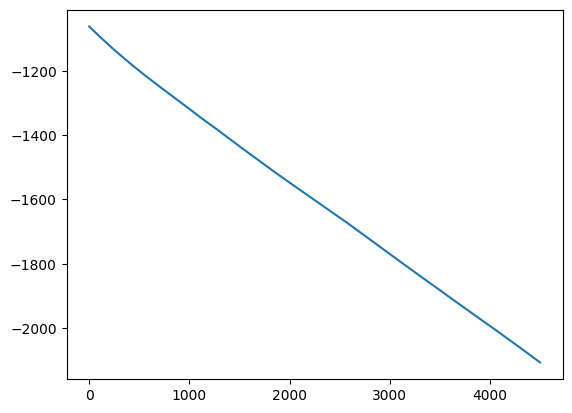

In [208]:
plt.plot(losses);

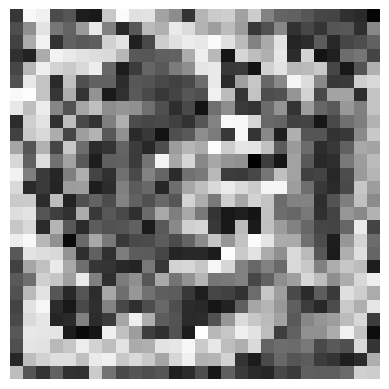

In [209]:
plt.imshow(im_ad.detach().squeeze().numpy(), cmap="gray")
plt.axis("off");

In [210]:
model(im_ad)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)

**The image even after 150 epochs of optimization of the input looks like a random noise, though intrestingly is being classified with a perfect confidence score- such an error is due to the intrinsic nature of the conv operation which checks only for the presence of the features but not their relative positionaning or the overall form and structure**

**! hence as long as your random noise has the features, it would be classified as a number**

###**1.9.2. Targeted attack**

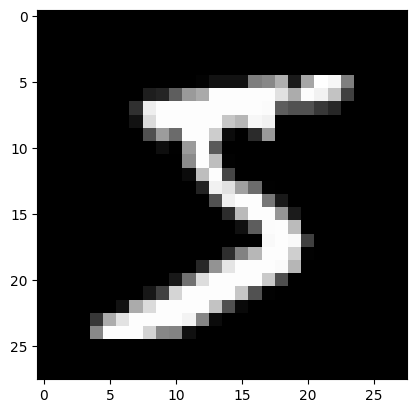

In [186]:
plt.imshow(im[0].squeeze(), cmap="gray")

In [187]:
im_ad=im[0].unsqueeze(0).clone()
im_ad=torch.nn.Parameter(im_ad, requires_grad=True)

In [188]:
model_ad=model[:-1]

In [189]:
optimizer= torch.optim.Adam([im_ad])
mse= nn.MSELoss()

In [190]:
def train_ad(model, model_ad, optimizer, im_ad, target_class, beta=1.0):
  model, model_ad= model.cpu(), model_ad.cpu()
  model.requires_grad_(False)
  model_ad.requires_grad_(False)
  logits= model_ad(im_ad)
  loss= beta*mse(im[0].squeeze(), im_ad.squeeze())-logits[0][target_class]
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  pred_probs=model(im_ad).max()
  return loss, pred_probs, model(im_ad).argmax()

EPOCH: 5 LOSS: -12.4740 PROB: 5 CONFIDENCE: 1.00

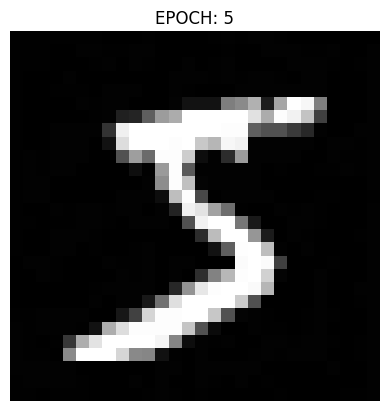

EPOCH: 10 LOSS: -14.0448 PROB: 5 CONFIDENCE: 1.00

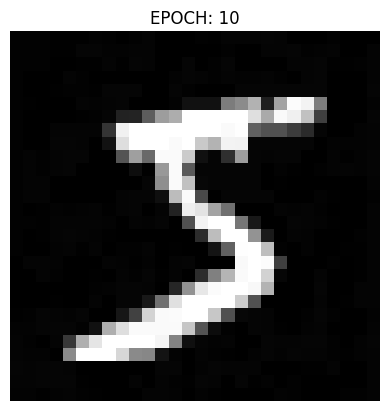

EPOCH: 15 LOSS: -15.6209 PROB: 5 CONFIDENCE: 1.00

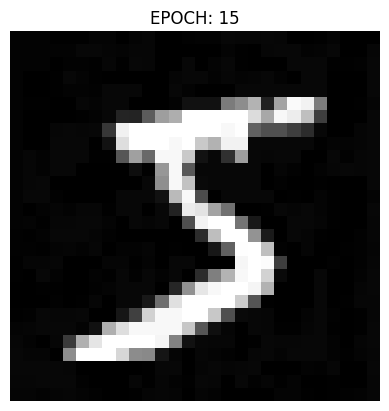

EPOCH: 20 LOSS: -17.2132 PROB: 5 CONFIDENCE: 1.00

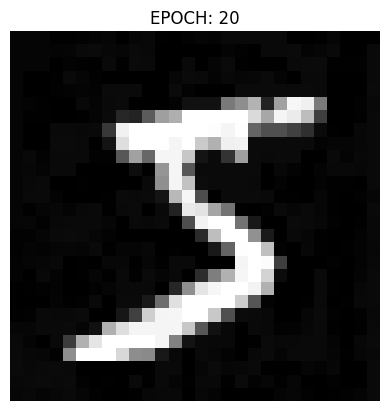

EPOCH: 25 LOSS: -18.7595 PROB: 5 CONFIDENCE: 1.00

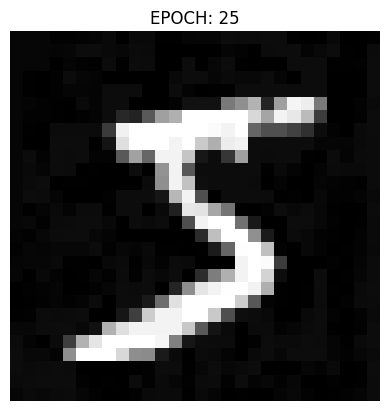

EPOCH: 30 LOSS: -20.3371 PROB: 5 CONFIDENCE: 1.00

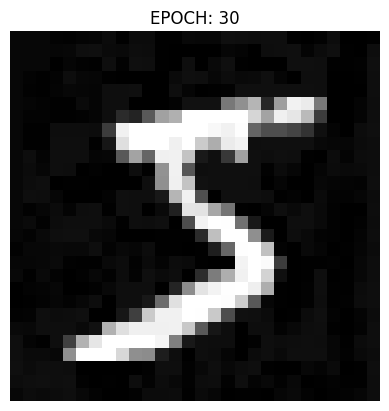

In [191]:
losses, confidence, probs=[], [], []
for i in range(30):
  loss, conf, pred_probs= train_ad(model, model_ad, optimizer, im_ad, 3)
  losses.append(loss.item())
  confidence.append(conf)
  probs.append(pred_probs.item())
  if (i+1)%5==0:
    print(f"EPOCH: {i+1} LOSS: {loss.item() :.4f} PROB: {pred_probs.item()} CONFIDENCE: {conf.item() :.2f}")
    plt.imshow(im_ad.detach().squeeze().numpy(), cmap="gray")
    plt.title(f"EPOCH: {i+1}")
    plt.axis("off")
    plt.show()

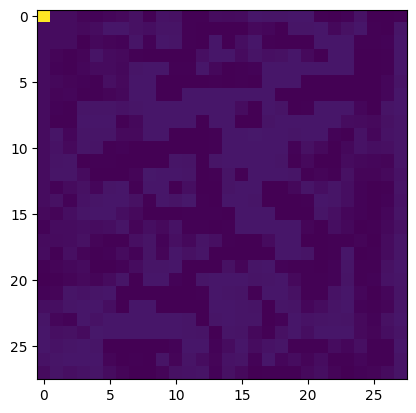

In [192]:
plt.imshow(im_ad.squeeze().detach().numpy()-im[0].squeeze().detach().numpy(), cmap="gray")
im_sub=im_ad.squeeze().detach().numpy()-im[0].squeeze().detach().numpy()
im_sub[0][0]=1
plt.imshow(im_sub);